In [1]:
import os, math
from collections import defaultdict
import itertools
import sqlite3

import logging
import logging.handlers

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [2]:
config = Config('SQLITE3')
RNG = np.random.default_rng()

if cp.cuda.is_available():
    device_marker = cp.empty(1)
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    device_marker = np.empty(1)
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
xp = cp.get_array_module(device_marker)
print(f'xp = {xp.__name__}')

log = logging.getLogger('kmslog')
log.setLevel(logging.DEBUG)

if not log.hasHandlers():
    log.addHandler(logging.handlers.SysLogHandler(address = '/dev/log', facility=logging.handlers.SysLogHandler.LOG_LOCAL0))

train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name))
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name))

xp = cupy


In [3]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 7.87 μs


((10000, 3), (2000, 3))

In [4]:
df_train_images.head()

,index,value,png
image_id,,,
27456,0,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
50770,1,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
9353,2,4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
50328,3,0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
18785,4,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [5]:
def matrix_to_image(m):
    m = m.ravel()
    sz = int(np.sqrt(m.shape[0]))
    assert sz * sz == m.shape[0]
    return Image.frombytes('L', size=(sz, sz), data=m.astype('b'))

In [6]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image


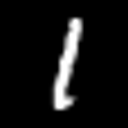
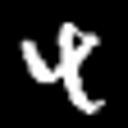
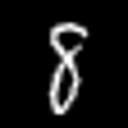
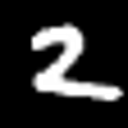
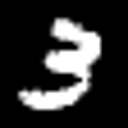
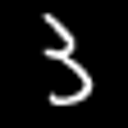
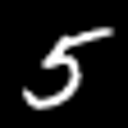
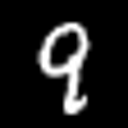
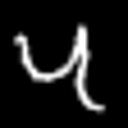
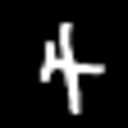
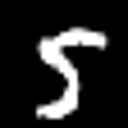
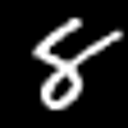
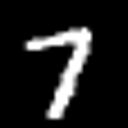
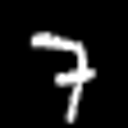
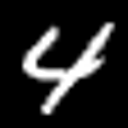
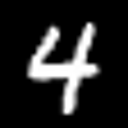

In [7]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [21]:
# COS_SIM_THRESHOLD = 0.075
COS_SIM_THRESHOLD = 0.055
hdc = Hdc(10_000, np)

In [22]:
class CorticalColumn(object):
    def __init__(self):
        self.clusters = defaultdict(list) # cluster = collection of image bundles for particular class
        self.cluster_norms = HdvArray(hdc.N, xp)
        self.cluster_to_image_ids = defaultdict(set)

In [23]:
COLUMN = CorticalColumn()
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

df_test_results = pd.DataFrame(columns=['source_ds', 'test_run_id', 'test_image_id', 'true_value', 'cluster_id', 'infer_value', 'sim'])

In [35]:
# TRAIN RUN
TRAIN_RUN_ID += 1
trials = 5
count = 10000
consolidation_threshold = 1000

for trial in tqdm(range(trials)):
    train_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    # EVOLVE MEMORIES
    for image_no, image_id in tqdm(enumerate(train_step_image_ids), leave=False, total=len(train_step_image_ids)):
        log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Cluster count={COLUMN.cluster_norms.len()}')
        
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) > 0
        image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
        image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
        image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)

        for _ in range(1):
            cos_sim_matrix = COLUMN.cluster_norms.array @ image_encoding_hdvs_norm.T
            # cos_sim_vector = xp_array_from_gpu(xp.max(cos_sim_matrix, axis=1)) # how each mem recall (max cos sim) is close to current image
            
            cos_sim_matrix[cos_sim_matrix < COS_SIM_THRESHOLD] = 0
            cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
            
            assert cos_sim_vector.shape == (COLUMN.cluster_norms.array.shape[0],)
            cluster_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc
            match_found = False
            match_is_top = False
            match_is_updated = False

            for pos, cluster_id in enumerate(cluster_ids_by_match_score):
                cos_sim_value = cos_sim_vector[cluster_id]
                log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Checking cluster #{cluster_id}, sim={cos_sim_value:.2f}')

                # if cos_sim_value < COS_SIM_THRESHOLD:
                #      # all remaining is less
                #     break

                if cos_sim_value <= 0:
                    break

                cluster_image_ids = COLUMN.cluster_to_image_ids[cluster_id]
                assert len(cluster_image_ids) > 0
                cluster_is_sealed = len(cluster_image_ids) > 200
                cluster_image_id = next(iter(cluster_image_ids))
                cluster_image_value = df_train_images.loc[cluster_image_id]['value']

                if cluster_image_value != image_value:
                    log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Match WRONG, pos={pos}, sealed={cluster_is_sealed}')

                    # if not cluster_is_sealed:
                    #     cluster_hdvs = COLUMN.clusters[cluster_id] # list
                    #     cluster_hdvs.append(hdc.complement(hdc.bundle(image_encoding_hdvs)))
                    #     new_cluster_bundle = xp_array_to_gpu(hdc.bundle(cluster_hdvs))
                    #     COLUMN.cluster_norms.array[cluster_id] = hdc.normalize(new_cluster_bundle)
                else:
                    log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Match CORRECT, pos={pos}, sealed={cluster_is_sealed}')

                    if not cluster_is_sealed:
                        cluster_image_ids.add(image_id)
                        cluster_hdvs = COLUMN.clusters[cluster_id] # list
                        cluster_hdvs.append(hdc.bundle(image_encoding_hdvs))
                        new_cluster_bundle = xp_array_to_gpu(hdc.bundle(cluster_hdvs))
                        COLUMN.cluster_norms.array[cluster_id] = hdc.normalize(new_cluster_bundle)

                    match_found = True
                    match_is_top = pos == 0
                    match_is_updated = not cluster_is_sealed
                    break

            log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Match found={match_found}, is top={match_is_top}, is updated={match_is_updated}')
                
            if (match_found and match_is_top) or (match_found and match_is_updated):
                break
        else:
            # Didn't find any matching cluster of HDVs to join -> create new one
            cluster_id = COLUMN.cluster_norms.lease()
            cluster_bundle = hdc.bundle(image_encoding_hdvs)
            COLUMN.cluster_norms.array[cluster_id] = xp_array_to_gpu(hdc.normalize(cluster_bundle))
            COLUMN.clusters[cluster_id].append(cluster_bundle)
            COLUMN.cluster_to_image_ids[cluster_id].add(image_id)
            log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] New cluster {cluster_id}')

        if image_no > 0 and image_no % consolidation_threshold == 0:
            # CONSOLIDATE MEMORY
            for cluster_id, image_ids in COLUMN.cluster_to_image_ids.items():
                log.debug(f'[train_run_id={TRAIN_RUN_ID}, consolidation] Before cluster #{cluster_id}, len={len(image_ids)}')
            
            before_len = COLUMN.cluster_norms.len()
            assert before_len == len(COLUMN.clusters)
            cluster_indices_to_release = []
            
            for cluster_id, image_ids in COLUMN.cluster_to_image_ids.items():
                l = 1
                exp_distro_level = l * np.exp(-l * len(image_ids))
                rand_level = RNG.random()
                do_release = rand_level < exp_distro_level
                
                if do_release:
                    cluster_indices_to_release.append(cluster_id)
                    log.debug(f'[train_run_id={TRAIN_RUN_ID}, consolidation] Dropping cluster #{cluster_id}, len={len(image_ids)}: {rand_level:.5f} < {exp_distro_level:.5f}')
        
            for cluster_index_to_release in cluster_indices_to_release:
                del COLUMN.clusters[cluster_index_to_release]
                del COLUMN.cluster_to_image_ids[cluster_index_to_release]
                COLUMN.cluster_norms.release(cluster_index_to_release)
        
            after_len = COLUMN.cluster_norms.len()
            assert after_len == len(COLUMN.clusters)
            
            for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
                log.debug(f'[train_run_id={TRAIN_RUN_ID}, consolidation] After cluster #{cluster_id}, len={len(image_ids)}')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [36]:
len(COLUMN.clusters)

183


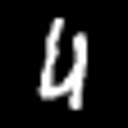
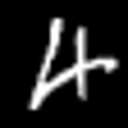
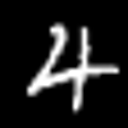
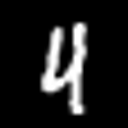
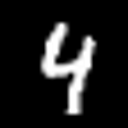
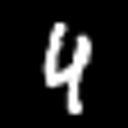
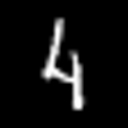
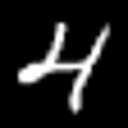
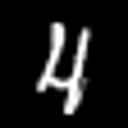
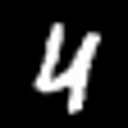
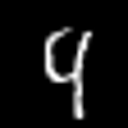

In [32]:
images = []
captions = []

if COLUMN.clusters.keys():
    random_cluster_i = RNG.choice(list(COLUMN.clusters.keys()))
    image_ids = COLUMN.cluster_to_image_ids[random_cluster_i]
    df_i = df_train_images.loc[list(image_ids)]
    image_datas = df_i['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    captions = list(map(lambda p: f'clust={random_cluster_i}, #{p[0]}, val={p[1]}', zip(df_i.index, df_i['value'])))

images = images[:32]
captions = captions[:32]
display_images_grid(images, captions=captions, col_count=8)

In [53]:
# TEST RUN
TEST_RUN_ID += 1
count = 2000
# source = (df_test_images, test_db_con, 'test')
source = (df_train_images, train_db_con, 'train')
test_image_ids = RNG.choice(source[0].index.unique(), count, replace=False)
test_result_rows = defaultdict(list)

for image_id in tqdm(test_image_ids):
    max_cos_sim_index = -1 # aka cluster id
    max_similar_cluster_image_value = ''
    max_cos_sim = 0

    image_value = source[0].loc[image_id]['value']
    df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=source[1])
    assert len(df_image_encodings) > 0
    image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
    image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
    image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)

    cos_sim_matrix = COLUMN.cluster_norms.array @ image_encoding_hdvs_norm.T
    
    # cos_sim_vector = xp_array_from_gpu(xp.max(cos_sim_matrix, axis=1)) # how each mem recall (max cos sim) is close to current image

    cos_sim_matrix[cos_sim_matrix < COS_SIM_THRESHOLD] = 0
    cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
    
    assert cos_sim_vector.shape == (COLUMN.cluster_norms.array.shape[0],)
    cluster_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc

    if cluster_ids_by_match_score.shape[0] > 0:
        cluster_id = cluster_ids_by_match_score[0]
        cos_sim_value = cos_sim_vector[cluster_id]

        # if cos_sim_value >= COS_SIM_THRESHOLD:
        if cos_sim_value > 0:
            cluster_image_ids = COLUMN.cluster_to_image_ids[cluster_id]
            assert len(cluster_image_ids) > 0
            cluster_image_id = next(iter(cluster_image_ids))
            cluster_image_value = df_train_images.loc[cluster_image_id]['value']
            max_cos_sim_index = cluster_id
            max_similar_cluster_image_value = cluster_image_value
            max_cos_sim = cos_sim_value
    
    test_result_rows['source_ds'].append(source[2])
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['cluster_id'].append(max_cos_sim_index)
    test_result_rows['infer_value'].append(max_similar_cluster_image_value)
    test_result_rows['sim'].append(max_cos_sim)
    

assert set(test_result_rows.keys()) == set(df_test_results.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=df_test_results.columns)
concat_list = [df_test_results] if len(df_test_results) > 0 else []
concat_list.append(df_test_results_for_run)
df_test_results = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [57]:
df_test_results_for_run

,test_run_id,test_image_id,true_value,cluster_id,infer_value,sim,source_ds
0,9,9122,9,110,9,8.349284,train
1,9,8396,7,34,7,4.938985,train
2,9,20502,2,12,2,3.487091,train
3,9,47854,5,118,5,6.895226,train
4,9,19410,1,305,1,9.258329,train
...,...,...,...,...,...,...,...
1995,9,51,0,6,0,5.394488,train
1996,9,39716,1,11,1,10.071418,train
1997,9,16927,3,107,3,4.004233,train
1998,9,13991,5,189,5,6.787394,train


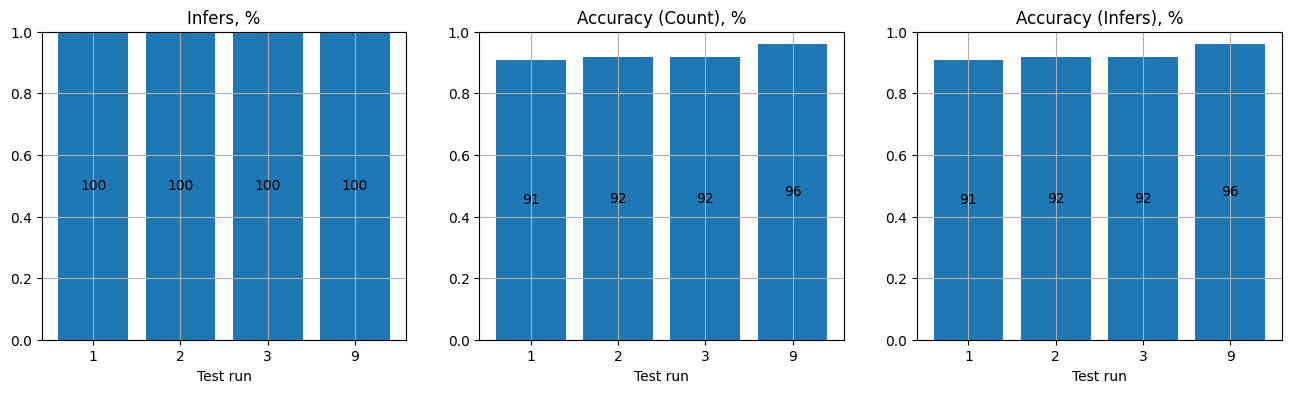

,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,
1,2000,2000,1818,1.0,0.9090,0.9090
2,2000,2000,1839,1.0,0.9195,0.9195
3,2000,2000,1837,1.0,0.9185,0.9185
9,2000,2000,1922,1.0,0.9610,0.9610


In [66]:
df_test_results2 = df_test_results.copy()
df_test_results2['is_infer'] = df_test_results2['cluster_id'] > -1
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'test_image_id': 'count', 'is_infer': 'sum', 'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [29]:
df_test_results_incorrect_infers = df_test_results_for_run[df_test_results_for_run['true_value'] != df_test_results_for_run['infer_value']]
incorrect_infer_row_index = RNG.choice(df_test_results_incorrect_infers.index.unique())
test_run_id = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_run_id']
incorrect_infer_image_id = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_image_id']
image_data = df_test_images.loc[incorrect_infer_image_id]['png']
image_value = df_test_images.loc[incorrect_infer_image_id]['value']

df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(incorrect_infer_image_id)}, con=test_db_con)
assert len(df_image_encodings) > 0
image_encoding_hdvs = map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv'])
df_x = pd.DataFrame(columns=['test_run_id', 'test_image_id', 'true_value', 'cluster_id', 'cluster_value', 'sim'])

for image_encoding_hdv in image_encoding_hdvs:
    image_encoding_hdv_norm = hdc.normalize(image_encoding_hdv)
    image_encoding_hdv_norm = xp_array_to_gpu(image_encoding_hdv_norm)
    cos_sims = COLUMN.cluster_norms.array @ image_encoding_hdv_norm
    max_cos_sim_index = int(xp.argmax(cos_sims))
    max_cos_sim = xp_array_from_gpu(cos_sims[max_cos_sim_index])

    if cos_sims[max_cos_sim_index] < COS_SIM_THRESHOLD:
        continue

    similar_cluster_image_ids = COLUMN.cluster_to_image_ids[max_cos_sim_index]
    assert len(similar_cluster_image_ids) > 0
    similar_cluster_image_id = next(iter(similar_cluster_image_ids))
    similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value'] # exactly from train! (i.e. we look for prototype in train data)
    df_x.loc[len(df_x)] = [test_run_id, incorrect_infer_image_id, image_value, max_cos_sim_index, similar_cluster_image_value, max_cos_sim]

df_x.sort_values(by='sim', ascending=False).head()

,test_run_id,test_image_id,true_value,cluster_id,cluster_value,sim
0,1,100001800,6,256,8,0.12199211386028665
13,1,100001800,6,16,2,0.11447533414992922
12,1,100001800,6,16,2,0.11336013546440003
40,1,100001800,6,16,2,0.11274973199883226
39,1,100001800,6,14,9,0.1124697915721893


In [210]:
df_x_pivot = pd.pivot_table(df_x, index='cluster_id', 
                            values=['true_value', 'cluster_value', 'sim'], 
                            aggfunc=dict(cluster_value='first', true_value='first', sim='sum'))
df_x_pivot.sort_values(by='sim', ascending=False)

,cluster_value,sim,true_value
cluster_id,,,
70,0,0.747907,5
207,5,0.738825,5
173,3,0.440719,5
78,0,0.398074,5
2,3,0.362198,5
16,2,0.312833,5
71,5,0.278002,5
60,6,0.223618,5
86,5,0.11246081332037595,5


In [100]:
df_x_pivot = pd.pivot_table(df_x, index='cluster_id', 
                            values=['true_value', 'cluster_value', 'sim'], 
                            aggfunc=dict(cluster_value='first', true_value='first', sim='max'))
df_x_pivot.sort_values(by='sim', ascending=False)

,cluster_value,sim,true_value
cluster_id,,,
19,3,0.12703890208008853,0
6,6,0.11769419304673903,0
4,3,0.10558864393968194,0
13,8,0.0997797655127572,0
9,2,0.09932921201809847,0
21,7,0.09553384113205146,0
11,8,0.08697738084024423,0
16,0,0.07189567141203239,0


In [109]:
df_test_results_for_run[df_test_results_for_run['test_image_id'] == 100000318]

,test_run_id,test_image_id,true_value,cluster_id,infer_value,sim
7,8,100000318,2,-1,,0.0
